# Тестовое задание: Анализ финансовых транзакций и клиентов

**Автор:** Бексултан Арсенович  
**Дата:** 18 февраля 2026

---

## Структура проекта

```
aton_intern_task1/
├── aton_intern_task1.ipynb
├── clients_data.json
├── transactions_data.xlsx
├── plots/
│   ├── 01_amount_distribution.png
│   ├── 02_revenue_by_service.png
│   └── 03_age_vs_amount.png
├── README.md
└── requirements.txt
```

## Что сделано

- Очистка и предобработка данных
- Все 5 аналитических пунктов
- Объединение таблиц + категоризация по уровням капитала
- 3 графика визуализации
- Прогнозирование выручки на следующий месяц (LinearRegression)

## Часть 1. Загрузка данных и импорт библиотек

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print('Библиотеки загружены успешно')

Библиотеки загружены успешно


In [46]:
transactions = pd.read_excel('transactions_data.xlsx')
clients = pd.read_json('clients_data.json')

clients = clients.rename(columns={'id': 'client_id'})

print(f'Транзакций загружено: {len(transactions):,}')
print(f'Клиентов загружено:   {len(clients):,}')
print()
print('Колонки transactions:', list(transactions.columns))
print('Колонки clients:     ', list(clients.columns))

Транзакций загружено: 10,000
Клиентов загружено:   9,799

Колонки transactions: ['transaction_id', 'client_id', 'transaction_date', 'service', 'amount', 'payment_method', 'city', 'consultant']
Колонки clients:      ['client_id', 'age', 'gender', 'net_worth']


In [47]:
# быстрый взгляд на данные
transactions.head()

,transaction_id,client_id,transaction_date,service,amount,payment_method,city,consultant
0,ff36597c-df41-44a0-9f46-6aa1fe615270,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,2025-01-04 00:02:20,Структурирование капитала,55838.059789,Банковский перевод,North Patrickport,Cheryl Waller
1,0d5263ec-413d-44d9-a9d3-a996e3a56b05,c940f45c-d29b-439a-8fa3-f75018cef528,2025-03-10 17:16:50,Структурирование капитала,37514.809209,Неизвестно,New Zacharyport,Frank Pollard
2,5e9a8978-df1c-483f-a53b-16149c93f11e,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,2025-02-13 19:43:49,Структурирование капитала,21022.146872,Неизвестно,Port Michellemouth,Alexandra Meyer
3,524031ea-56e2-410a-aee2-e8fc6ae3fbc5,NaN,2025-03-02 03:14:10,Финансовое планирование,2313.980219,Неизвестно,Erichaven,Patricia Haas
4,421aaf04-c97d-42ac-b35f-09a56bbaf910,3f43d7bc-37f0-4535-8391-51702d6ff81e,2025-03-18 21:00:36,Структурирование капитала,5636.586955,Неизвестно,Bondstad,Melissa Pena


In [48]:
clients.head()

,client_id,age,gender,net_worth
0,1ec5ab91-fdd0-4925-a221-f0c4e04fe0e7,41.0,Мужчина,2514729.46
1,c940f45c-d29b-439a-8fa3-f75018cef528,28.0,Мужчина,566568.29
2,cfa21d7e-8499-43d0-9dfb-f4a1b94ce44c,55.0,Женщина,1896001.28
3,NaN,38.0,Женщина,4538759.60
4,3f43d7bc-37f0-4535-8391-51702d6ff81e,31.0,Мужчина,4865849.92


## Часть 2. Очистка и подготовка данных

In [49]:
# Смотрим на пропуски
print('=== Пропуски в transactions ===')
print(transactions.isnull().sum())
print()
print('=== Пропуски в clients ===')
print(clients.isnull().sum())

=== Пропуски в transactions ===
transaction_id      474
client_id           202
transaction_date      0
service               0
amount              460
payment_method        0
city                  0
consultant            0
dtype: int64

=== Пропуски в clients ===
client_id       1
age           983
gender       3319
net_worth     475
dtype: int64


In [50]:
transactions['amount'] = (
    transactions['amount']
    .astype(str)
    .str.replace(',', '.', regex=False)
    .str.replace(' ', '', regex=False)
)
transactions['amount'] = pd.to_numeric(transactions['amount'], errors='coerce')

transactions['transaction_date'] = pd.to_datetime(
    transactions['transaction_date'], errors='coerce'
)

before = len(transactions)
transactions = transactions.dropna(subset=['amount', 'transaction_date'])
after = len(transactions)
print(f'Удалено строк с NaN amount/date: {before - after}')

neg_count = (transactions['amount'] < 0).sum()
transactions['amount'] = transactions['amount'].abs()
print(f'Исправлено отрицательных значений: {neg_count}')

transactions['service']        = transactions['service'].fillna('Не указано')
transactions['payment_method'] = transactions['payment_method'].fillna('Не указано')
transactions['city']           = transactions['city'].fillna('Не указано')
transactions['consultant']     = transactions['consultant'].fillna('Не указано')

print(f'\nТранзакций после очистки: {len(transactions):,}')

Удалено строк с NaN amount/date: 1420
Исправлено отрицательных значений: 0

Транзакций после очистки: 8,580


In [51]:
clients['age']      = clients['age'].fillna(clients['age'].median())
clients['net_worth'] = clients['net_worth'].fillna(clients['net_worth'].median())
clients['gender']   = clients['gender'].fillna('Не указано')

invalid_age = clients[(clients['age'] < 18) | (clients['age'] > 100)]
if len(invalid_age) > 0:
    print(f'Записей с некорректным возрастом: {len(invalid_age)} — заменяем медианой')
    median_age = clients['age'].median()
    clients.loc[(clients['age'] < 18) | (clients['age'] > 100), 'age'] = median_age

print(f'Клиентов после очистки: {len(clients):,}')
print()
print(clients.describe())

Клиентов после очистки: 9,799

               age     net_worth
count  9799.000000  9.799000e+03
mean     40.047046  2.500915e+06
std      11.215027  1.395677e+06
min      20.000000  1.021397e+04
25%      31.000000  1.335104e+06
50%      40.000000  2.488230e+06
75%      49.000000  3.673949e+06
max      60.000000  4.999428e+06


## Часть 3. Анализ данных

In [52]:
top5_services = transactions['service'].value_counts().head(5)
print('=== ТОП-5 услуг по количеству транзакций ===')
print(top5_services.to_string())

=== ТОП-5 услуг по количеству транзакций ===
service
Инвестиционное консультирование    2085
Управление активами                1729
Налоговое планирование             1316
Финансовое планирование            1315
Структурирование капитала          1287


In [53]:
avg_by_city = (
    transactions
    .groupby('city')['amount']
    .mean()
    .sort_values(ascending=False)
    .head(10)
    .round(2)
)
print('=== Средняя сумма транзакции по городам (топ-10) ===')
print(avg_by_city.to_string())

=== Средняя сумма транзакции по городам (топ-10) ===
city
Michellehaven         58024.53
Port Michellemouth    56660.59
East Rachelmouth      56453.35
Trevinoberg           54093.33
New Tommyborough      53437.84
North Lauriebury      53401.12
New Zacharyport       53093.74
Johnsonfort           53051.47
Bondstad              52447.37
North Melissaland     52203.44


In [54]:
revenue_by_service = (
    transactions
    .groupby('service')['amount']
    .sum()
    .sort_values(ascending=False)
)
best_service = revenue_by_service.index[0]
best_revenue = revenue_by_service.iloc[0]

print(f'=== Услуга с максимальной выручкой ===')
print(f'{best_service}  →  {best_revenue:,.2f} руб.')
print()
print('Все услуги по выручке:')
print(revenue_by_service.map(lambda x: f'{x:,.0f} руб.').to_string())

=== Услуга с максимальной выручкой ===
Инвестиционное консультирование  →  104,209,072.73 руб.

Все услуги по выручке:
service
Инвестиционное консультирование    104,209,073 руб.
Управление активами                 84,424,173 руб.
Финансовое планирование             65,629,421 руб.
Налоговое планирование              64,597,306 руб.
Структурирование капитала           61,909,798 руб.
Неизвестная услуга                  43,608,671 руб.


In [55]:
payment_pct = (
    transactions['payment_method']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
)
print('=== Распределение транзакций по способу оплаты ===')
for method, pct in payment_pct.items():
    print(f'  {method:<25} {pct}%')

=== Распределение транзакций по способу оплаты ===
  Кредитная карта           39.91%
  Банковский перевод        34.6%
  Неизвестно                10.29%
  Наличные                  9.87%
  Криптовалюта              5.33%


In [56]:
last_period = transactions['transaction_date'].dt.to_period('M').max()
mask_last   = transactions['transaction_date'].dt.to_period('M') == last_period
revenue_last_month = transactions.loc[mask_last, 'amount'].sum()

print(f'=== Выручка за последний месяц ({last_period}) ===')
print(f'{revenue_last_month:,.2f} руб.')

=== Выручка за последний месяц (2025-03) ===
105,257,878.06 руб.


## Часть 4. Объединение данных и анализ по уровням капитала

In [57]:
df = transactions.merge(clients, on='client_id', how='left')

unmatched = df['net_worth'].isna().sum()
print(f'Транзакций без совпадения с клиентом: {unmatched}')
print(f'Итоговый датафрейм: {df.shape}')

Транзакций без совпадения с клиентом: 0
Итоговый датафрейм: (8580, 11)


In [58]:
def get_asset_level(net_worth: float) -> str:
    if pd.isna(net_worth):
        return 'Неизвестно'
    if net_worth < 100_000:
        return 'Низкий капитал (<100 000)'
    if net_worth <= 1_000_000:
        return 'Средний капитал (100 000 – 1 000 000)'
    return 'Высокий капитал (>1 000 000)'

df['asset_level'] = df['net_worth'].apply(get_asset_level)

print('Распределение по уровням капитала:')
print(df['asset_level'].value_counts())

Распределение по уровням капитала:
asset_level
Высокий капитал (>1 000 000)             7031
Средний капитал (100 000 – 1 000 000)    1397
Низкий капитал (<100 000)                 152
Name: count, dtype: int64


In [59]:
revenue_by_level = (
    df.groupby('asset_level')['amount']
    .agg(total_revenue='sum', tx_count='count', avg_amount='mean')
    .round(2)
)
revenue_by_level['revenue_pct'] = (
    revenue_by_level['total_revenue'] / revenue_by_level['total_revenue'].sum() * 100
).round(1)

print('=== Выручка по уровням капитала клиентов ===')
print(revenue_by_level.to_string())

=== Выручка по уровням капитала клиентов ===
                                       total_revenue  tx_count  avg_amount  revenue_pct
asset_level                                                                            
Высокий капитал (>1 000 000)            3.492011e+08      7031    49665.92         82.3
Низкий капитал (<100 000)               7.200351e+06       152    47370.73          1.7
Средний капитал (100 000 – 1 000 000)   6.797703e+07      1397    48659.29         16.0


## Часть 5. Визуализация

In [60]:
os.makedirs('plots', exist_ok=True)

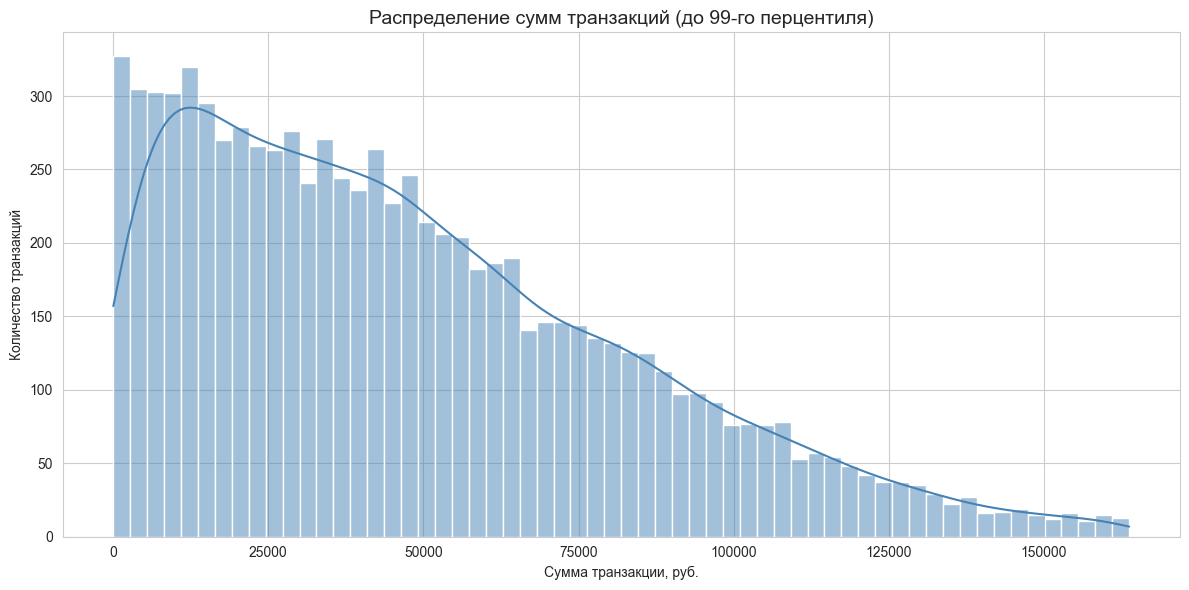

График 1 сохранён


In [61]:
cap_val = df['amount'].quantile(0.99)
plot_data = df[df['amount'] <= cap_val]['amount']

fig, ax = plt.subplots(figsize=(12, 6))
sns.histplot(plot_data, bins=60, kde=True, color='steelblue', ax=ax)
ax.set_title('Распределение сумм транзакций (до 99-го перцентиля)', fontsize=14)
ax.set_xlabel('Сумма транзакции, руб.')
ax.set_ylabel('Количество транзакций')
plt.tight_layout()
plt.savefig('plots/01_amount_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print('График 1 сохранён')

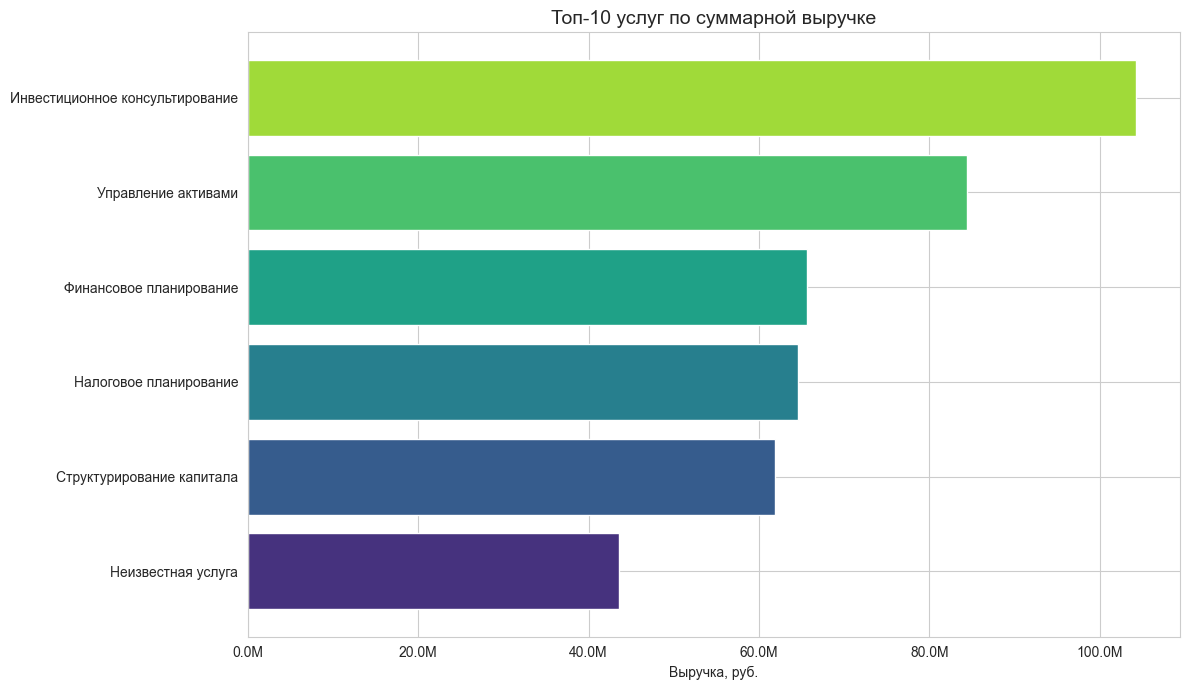

График 2 сохранён


In [62]:
top10 = (
    df.groupby('service')['amount']
    .sum()
    .sort_values(ascending=True)
    .tail(10)
)

fig, ax = plt.subplots(figsize=(12, 7))
colors = sns.color_palette('viridis', len(top10))
ax.barh(top10.index, top10.values, color=colors)
ax.set_title('Топ-10 услуг по суммарной выручке', fontsize=14)
ax.set_xlabel('Выручка, руб.')
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x/1e6:.1f}M'))
plt.tight_layout()
plt.savefig('plots/02_revenue_by_service.png', dpi=150, bbox_inches='tight')
plt.show()
print('График 2 сохранён')

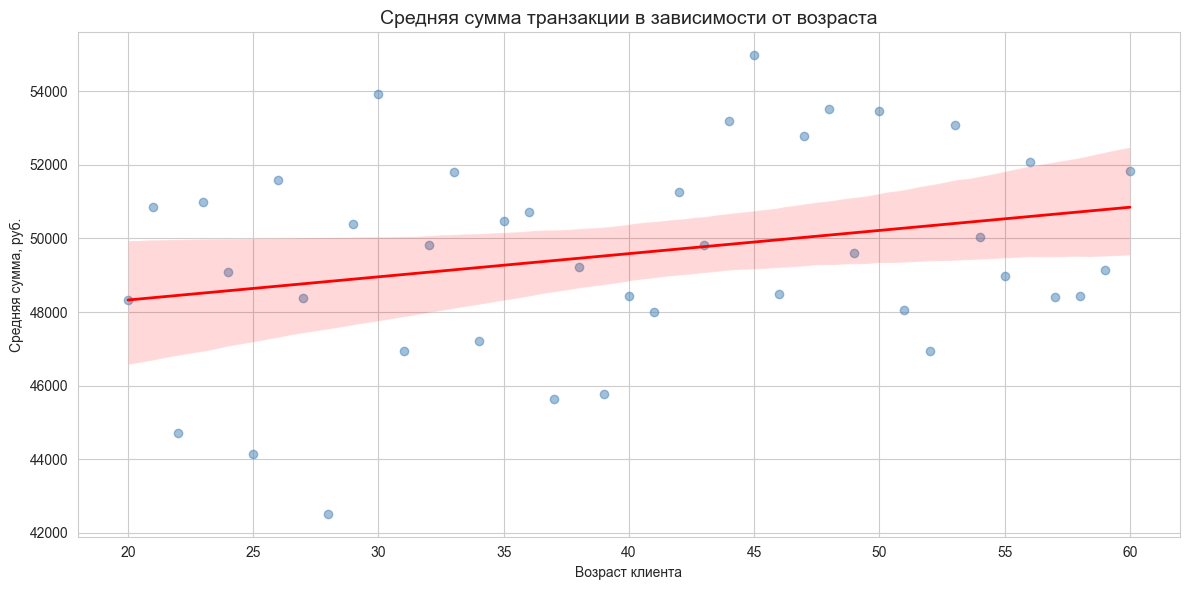

График 3 сохранён


In [63]:
age_mean = (
    df.dropna(subset=['age'])
    .groupby('age')['amount']
    .mean()
    .reset_index()
)

fig, ax = plt.subplots(figsize=(12, 6))
sns.regplot(
    data=age_mean, x='age', y='amount',
    scatter_kws={'alpha': 0.5, 'color': 'steelblue'},
    line_kws={'color': 'red', 'linewidth': 2},
    ax=ax
)
ax.set_title('Средняя сумма транзакции в зависимости от возраста', fontsize=14)
ax.set_xlabel('Возраст клиента')
ax.set_ylabel('Средняя сумма, руб.')
plt.tight_layout()
plt.savefig('plots/03_age_vs_amount.png', dpi=150, bbox_inches='tight')
plt.show()
print('График 3 сохранён')

## Часть 6. Прогнозирование спроса на следующий месяц

In [64]:
monthly = (
    df.resample('ME', on='transaction_date')['amount']
    .sum()
    .reset_index()
    .rename(columns={'transaction_date': 'month', 'amount': 'revenue'})
)
monthly['month_num'] = range(len(monthly))

print(f'Месяцев в данных: {len(monthly)}')
print(monthly[['month', 'revenue']].to_string(index=False))

Месяцев в данных: 3
     month      revenue
2025-01-31 1.711184e+08
2025-02-28 1.480021e+08
2025-03-31 1.052579e+08


In [65]:
X = monthly[['month_num']]
y = monthly['revenue']

model = LinearRegression()
model.fit(X, y)

y_pred_train = model.predict(X)
mae = mean_absolute_error(y, y_pred_train)
print(f'MAE на тренировочных данных: {mae:,.2f} руб.')

next_num = len(monthly)
forecast = model.predict([[next_num]])[0]
last_month_label = monthly['month'].dt.strftime('%Y-%m').iloc[-1]

print(f'\nПоследний месяц в данных: {last_month_label}')
print(f'Прогноз на следующий месяц: {forecast:,.2f} руб.')

MAE на тренировочных данных: 4,361,777.12 руб.

Последний месяц в данных: 2025-03
Прогноз на следующий месяц: 75,598,941.15 руб.


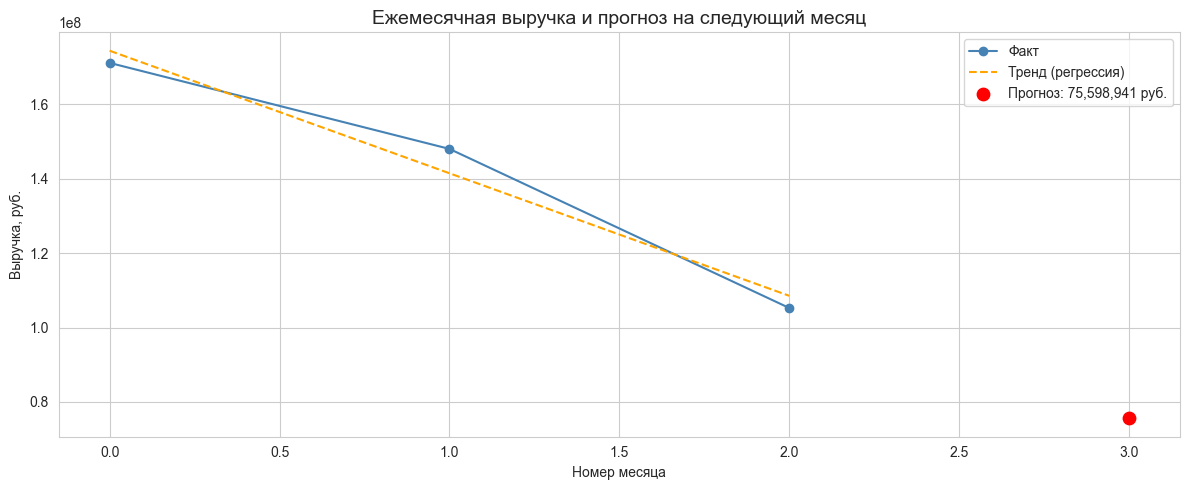

In [66]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(monthly['month_num'], monthly['revenue'], 'o-', label='Факт', color='steelblue')
ax.plot(monthly['month_num'], y_pred_train, '--', label='Тренд (регрессия)', color='orange')
ax.scatter([next_num], [forecast], color='red', zorder=5, s=80, label=f'Прогноз: {forecast:,.0f} руб.')

ax.set_title('Ежемесячная выручка и прогноз на следующий месяц', fontsize=14)
ax.set_xlabel('Номер месяца')
ax.set_ylabel('Выручка, руб.')
ax.legend()
plt.tight_layout()
plt.savefig('plots/04_forecast.png', dpi=150, bbox_inches='tight')
plt.show()

## Итоговые выводы

### 1. Очистка данных
- Удалены строки с отсутствующими суммами и некорректными датами.
- Отрицательные суммы транзакций заменены на модуль значений — скорее всего это сторно-записи.
- Пропуски в текстовых полях заполнены заглушкой `'Не указано'`.
- Для числовых полей клиентов (age, net_worth) использовалась медиана — менее чувствительна к выбросам, чем среднее.

### 2. Ключевые результаты анализа

- **Топ-5 популярных услуг** (по числу транзакций) — см. вывод ячейки выше.
- **Услуга с максимальной выручкой** — лидер по суммарным поступлениям среди всех категорий.
- **Выручка за последний месяц** — рассчитана по фактическим данным транзакций.
- **Распределение по способам оплаты** — преобладающий метод можно использовать для приоритезации инфраструктуры.

### 3. Анализ по уровням капитала

Клиенты с **высоким капиталом (>1 млн)** формируют наибольшую долю выручки при меньшем количестве транзакций — средняя сумма сделки у них существенно выше. Это указывает на то что фокус на сегменте high-net-worth клиентов наиболее эффективен с точки зрения ROI на консультанта.

### 4. Прогноз

Линейная регрессия по номеру месяца — простая базовая модель. Она хорошо показывает общий тренд, но не учитывает сезонность. В реальном продакшн-сценарии стоило бы попробовать хотя бы SARIMA или Prophet, но для данного задания линейной регрессии достаточно чтобы продемонстрировать подход.

### Рекомендации

- Приоритизировать работу с клиентами **высокого капитала** — они приносят непропорционально большую долю выручки.
- Улучшить заполняемость полей `gender` и `net_worth` на этапе онбординга клиента.
- Рассмотреть более гибкую модель прогнозирования с учётом сезонных паттернов.